# Solving linear system of equations using QUBO

In this example we demonstrate how to use a QUBO approach to solve linear system of equations. Let's first define a small random linear system of equations. 

$$
A x = b
$$

In [17]:
import numpy as np
np.random.seed(20)

Let's define the matrix $A$:

In [18]:
size = 4
A = np.random.rand(size,size)
A = 0.1*(A+A.T)

and the right hand side vector $b$:

In [19]:
b =  np.random.rand(size,1)

## Classical Solution

The solution of such a small system can be obtained by a least square as implemented in numpy

In [20]:
npsol = np.linalg.solve(A,b)
npsol = np.asarray(npsol).flatten()
print(npsol)

[-0.37072381  6.30320449 -3.71869512  0.92589866]


## 2. QUBO formalism for linear systems

The Quandratic Unconstrainted Binary Optimization problem, or QUBO, allows to minimize the cost function :

$$
E(x) = x^{T}Qx
$$

where the variables $x_i$ are binaries, i.e. the are 0 or 1. The equation above can be rewritten as :

$$
E(x) = \sum_i Q_{ii}x_i + \sum_{ij} Q_{ij}x_ix_j
$$

that is very similar to the Ising model, basis of the quantum annealler architecture. 

### Encoding real numbers in binary variables

In the QUBO problems, variables are binaries and we of course want to solve for real numbers in our case. There ar e different ways to encode real numbers in multiple binaries. In our case since the variables are between -1.0 and 1.0 we can use the following encoding : 

$$
r_i = a \sum_n x_n 2^{n} - x_{k+n} 2^{n} 
$$

where $a$ is a normalization constant. THis encoding is created in the `SolutionVector` class that allows to encode/decode real numbers in a series of binaries variables. We use here the `RealUnitQbitEncoding` to obtain real numbers between -1 and 1. The number of qbit controls the precision of the reals we can obtain.

### Linear systems

To solve a linear system $Ax=b$ with QUBO we need to minimize the following loss 

$$
E(x) = ||Ax-b||^2 =(Ax-b)^T (Ax-b) = x^T A^T A x-b^T A x-A x b^T+ b^T b = x^T Q x + ||b||^2
$$

We can ignore the last terms as it doesn't contribute to the optimization process. The $Q$ matrix can be defined through the different terms of the expression. This is achieved by the `create_qubo_matrix` methods that returns a `dict` containing the weights (diagonal terms) and strengths (off diagonal terms) of the $Q$ matrix. 

## 3. Solving the system

We will use here the `SimulatedAnnealingSampler` to be able to run that code locally. We use only 50 `reads`. Quantum solvers are available through the Leap cloud service.

We use here a `RangedEfficienEncoding` that encodes real values using $N$ qbits following:

$$
x = -2^{N-1} a q_0 + \sum_{n=0}^{N-2} 2^{n} a q_{n+1}
$$

We use here 4 qubits per float and define the range $a=10$ 

In [ ]:
from qubols.qubols import QUBOLS
from qubols.encodings import RangedEfficientEncoding
from dwave.samplers import SimulatedAnnealingSampler

options = {'num_reads':50, 'sampler':SimulatedAnnealingSampler(), 
           'encoding': RangedEfficientEncoding, 'num_qbits':4, 'range':10.0}
qubols= QUBOLS(options)
sol_num = qubols.solve(A, b)

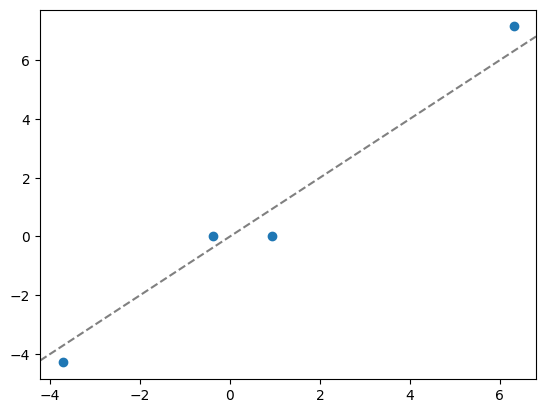

In [33]:
import matplotlib.pyplot as plt
plt.scatter(npsol, sol_num)
plt.axline( (0,0),slope=1,linestyle='--',color='gray')

We see here that due to the limited number of qubits that has been used, the accuracy of the solution is not ideal. We can of course increase the number of qubits to get better results:

In [28]:
options = {'num_reads':50, 'sampler':SimulatedAnnealingSampler(), 
           'encoding': RangedEfficientEncoding, 'num_qbits':6, 'range':10.0}
qubols= QUBOLS(options)
sol_num = qubols.solve(A, b)

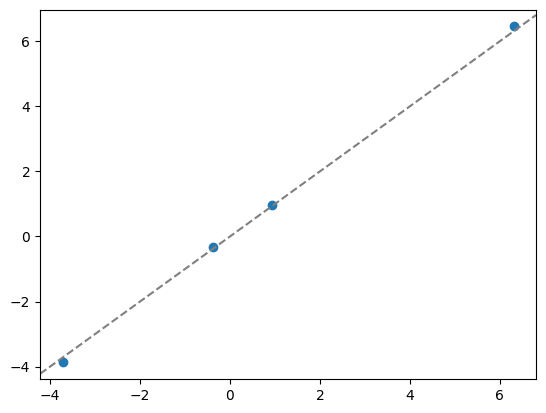

In [29]:
import matplotlib.pyplot as plt
plt.scatter(npsol, sol_num)
plt.axline( (0,0),slope=1,linestyle='--',color='gray')

## 4. Using Adaptative Encoding

To increase precision, we can use an adaptive ecoding that gets progressively refined over a few iterations. In that scheme the range, $a$ of each float encoding may start say at 10.0 but gets narrowed down to a smaller range in order to increase the accuracy of the solution without requiring to use more qubits.

In [23]:
from qubols.aequbols import AEQUBOLS

We use here the simulated annealing sampler with 50 reads. We use 4 qubits and reduce the encoding range over 3 iterations.

In [34]:
options = {'sampler':SimulatedAnnealingSampler(), 'num_reads':50,  
           'encoding': RangedEfficientEncoding, 'num_qbits':4, 'range':10.0,
           'iterations':3}
qubols= AEQUBOLS(options)
sol_num = qubols.solve(A, b)

{'sampler': <dwave.samplers.sa.sampler.SimulatedAnnealingSampler object at 0x712b42609f40>, 'num_reads': 50, 'encoding': <class 'qubols.encodings.RangedEfficientEncoding'>, 'num_qbits': 4, 'range': 10.0, 'iterations': 3}
0 [0.0, 0.0, 0.0, 0.0] 10.0
1 [-0.00024151682869757453, 5.714395170922581, -4.285472951360631, 1.428462154409604] [2.577928293361607, 2.7853845958751866, 2.180619646067677, 1.400874362529287]
2 [-0.3986501189193587, 6.285788696835706, -3.767806108593923, 0.9961629845502049] [0.5526095843990394, 0.6368582611654345, 0.5331949702515402, 0.2671798699044006]


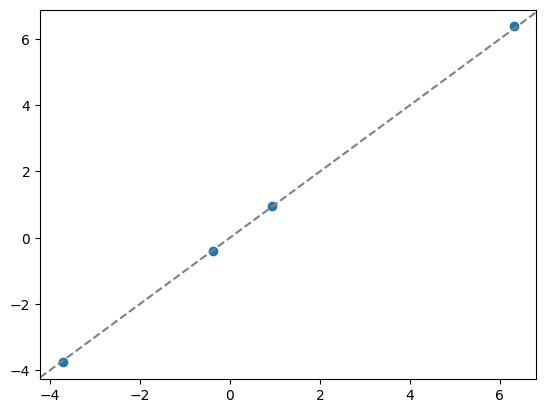

In [35]:
import matplotlib.pyplot as plt
plt.scatter(npsol, sol_num)
plt.axline( (0,0),slope=1,linestyle='--',color='gray')

We see here that we obtain with 4 qubits per float a similar accuracy than the one we had with 6 qubits. 